# Setup

In [1]:
#@title ## Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display
import os

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

import warnings
warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [2]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
      sys.path.insert(0,new_path)
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()

#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
from inverting import euler_inversion
import plotting
import viscoporoelastic_model

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [27]:
#@title ## Specific imports for bessel functions

# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x):      return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x):      return sp.special.iv(1, x) #besseli(1, x)
def Iv(x,v):    return sp.special.iv(v, x)
def J0(x):      return sp.special.jv(0, x)
def J1(x):      return sp.special.jv(1, x)
def Jv(x,v):    return sp.special.jv(v, x)
def ln(x):      return np.log(x)  #import math #return math.log(x)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[-757.98-0.j    0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new inst

(-30.0, 50.0)

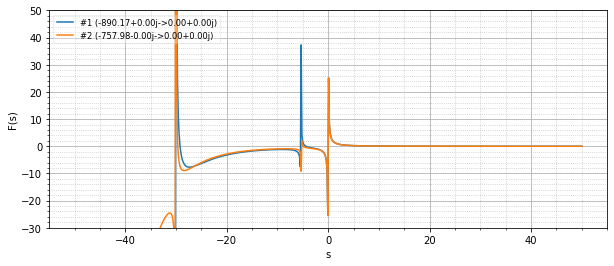

In [6]:
import inverting
from viscoporoelastic_model import CohenModel, CohenModel1998
importlib.reload(inverting)
importlib.reload(viscoporoelastic_model)

def getCohenModelModified(**kwargs):
    class CohenModelModified(CohenModel):
        superclass = CohenModel
        t0_tg   = kwargs.get("t0_tg",   superclass.t0_tg)  #10 / 40.62;
        tg      = kwargs.get("tg",      superclass.tg)  #40.62  # sec
        strain_rate = kwargs.get("strain_rate", superclass.strain_rate)  #0.01;  # per sec
        E1      = kwargs.get("E1",      superclass.E1)  #8.5  # kPa
        E3      = kwargs.get("E3",      superclass.E3)  #19  # kPa
        v21     = kwargs.get("v21",     superclass.v21) #0.75  # like Vrtheta
        v31     = kwargs.get("v31",     superclass.v31) #0.24  # like Vrz
    return CohenModelModified()

VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") ]

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 

F_s_recalcs = [
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s, times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_analytical_all[ind], plot_s, times=input_times_anal ) for ind, _ in enumerate(VPEs) ],
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],

               #*[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s, times=np.linspace(0, 100, num=100001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s, F_s_recalc, label=f"#{ind+1} ({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.xlim([-0.5,None])
plt.ylim([-30, 50])

#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)


<IPython.core.display.Javascript object>

$Cohen$


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


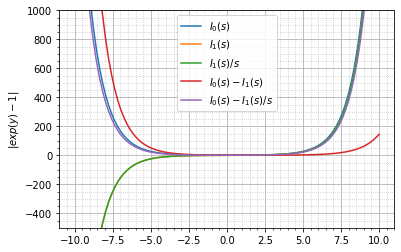

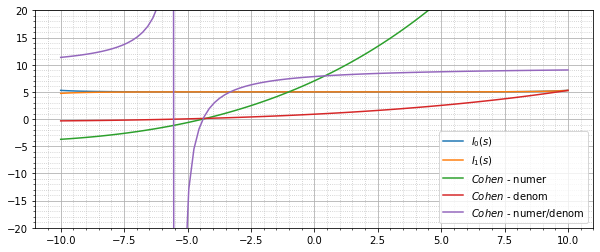

In [76]:

def ychange(vals):
    return vals
    return np.log1p(np.abs(vals))

s=np.linspace(start=-10, stop=10, num=100, endpoint=True)
plt.figure()
for v in [0,1]:
    plt.plot(s, ychange(Iv(s,v=v)), label=f"$I_{v}(s)$")
plt.plot(s, ychange(I1(s)), label=f"$I_{1}(s)/s$")
plt.plot(s, ychange(I0(s)-I1(s)), label=f"$I_{0}(s)-I_{1}(s)$")
plt.plot(s, ychange(I0(s)-I1(s)/s), label=f"$I_{0}(s)-I_{1}(s)/s$")
plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.ylabel("$|exp(y)-1|$")
plt.ylim([-500,1000])


exp = np.exp
sqrt = np.sqrt

VPEs = [(CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
    

def ychange(vals):
    return vals


s=np.linspace(start=-10, stop=10, num=100, endpoint=True)+0j
fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for v in [0,1]:
    #pass
    plt.plot(s, ychange(Iv(s,v=v)*1e-4+5), label=f"$I_{v}(s)$")

for vpe, label in VPEs:
    print(name)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()

    I1rts_s = I1(sqrt(s)) / sqrt(s)
    I0rts = I0(sqrt(s))
    eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s))/ (s*s)
    numer = (C1*I0rts - C2*C0*I1rts_s)  #* (1 - exp(-t0_tg * s)) 
    denom = (I0rts - C0*I1rts_s)        #* s*s
    plt.plot(s,ychange(numer), label=label+" - numer")
    plt.plot(s,ychange(denom), label=label+" - denom")
    plt.plot(s,ychange(numer/denom), label=label+" - numer/denom")
    #plt.plot(s,ychange(vpe.laplace_value(s)), label=label)

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.ylim([-20,20])
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.yscale('log')

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

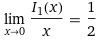

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
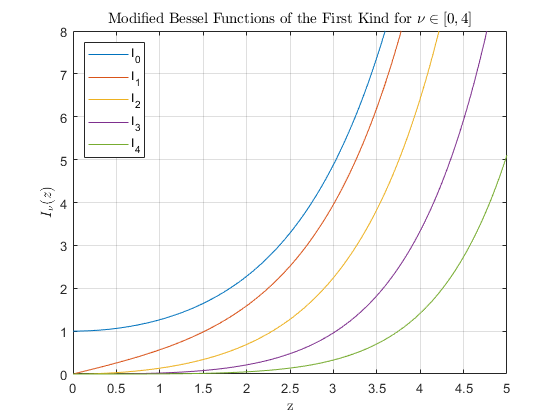

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

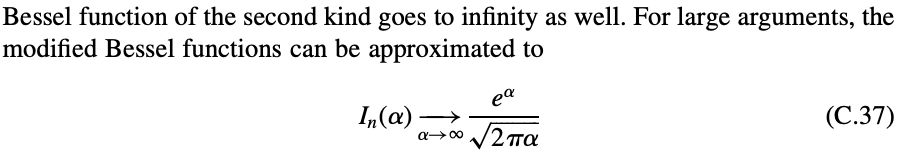


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

## https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

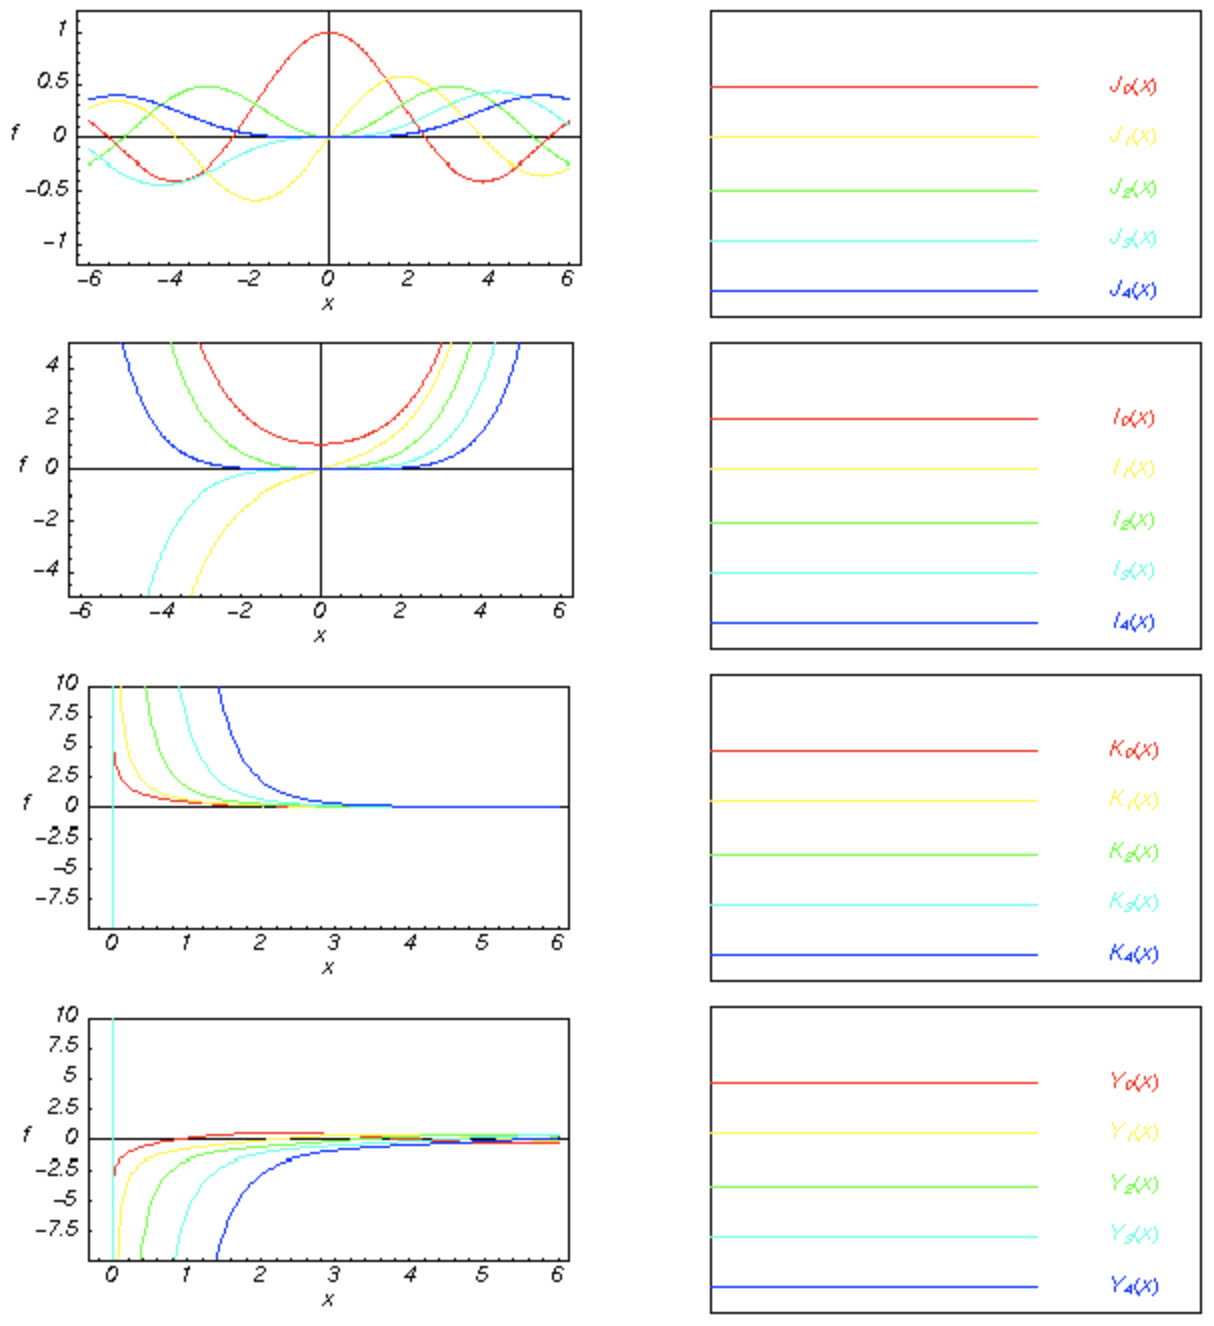

## Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx} + (x^2 - ν^2 )y=0$

is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions of the first and second kind as follows:

$y=A J_ν(x)+B Y_ν(x)$

where $A$ and $B$ are arbitrary constants. While Bessel functions are often presented in text books and tables in the form of integer order, i.e. $ν=0, 1 , 2 ,...$, in fact they are defined for all real values of $−∞<ν<∞$.

### 2. Bessel Functions

a) First Kind: $Jν(x)$ in the solution to Bessel’s equation is referred to as a Bessel function of the first kind.

b) Second Kind: $Yν(x)$ in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.

b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as


$Hν(1)(x)=Jν(x)+iYν(x), x> 0$  
$Hν(2)(x)=Jν(x)−iYν(x), x> 0$  


Because of the linear independence of the Bessel function of the first and second kind, the Hankel functions provide an alternative pair of solutions to the Bessel differential equation.

### 3. Modified Bessel Equation

By letting $x= ix$ (where $i=\sqrt{-1}$) in the Bessel equation we can obtain the modified Bessel equation of order ν, given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx}- (x^2 +ν^2 )y=0$


The solution to the modified Bessel equation yields modified Bessel functions of the first and second kind as follows:

$y=CIν(x)+DKν(x), x> 0$  

### 4. Modified Bessel Functions

a) First Kind: $Iν(x)$ in the solution to the modified Bessel’s equation is referred to as a modified Bessel function of the first kind.  

b) Second Kind: $Kν(x)$ in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.  


$I_0(x)=J_0(i \cdot x)$  
$I_1(x)=-i\cdot J_1(i \cdot x)$  
$I_2(x)=- J_2(i \cdot x)$  
$I_\nu(x)=i^{-\nu} \cdot J_\nu(i \cdot x)=J_\nu(i^{3/2} \cdot x)$   


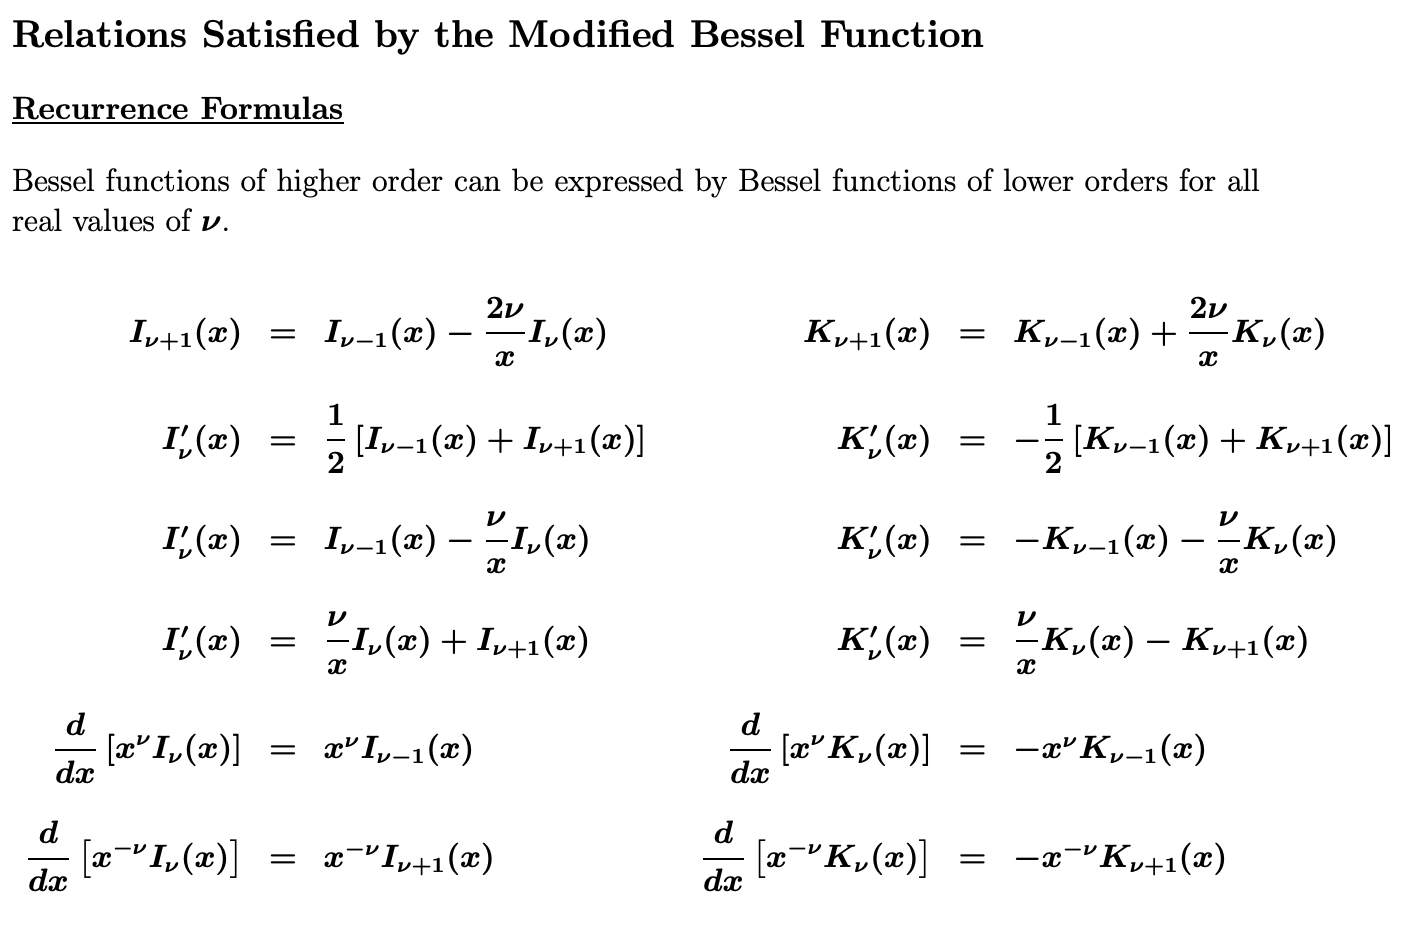

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

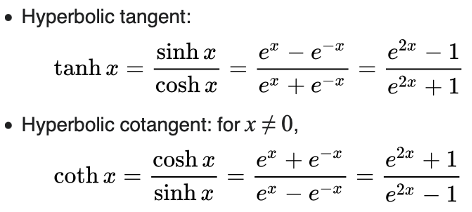